---

# **Modeling Song Popularity: The Impact of Audio Features and Streaming Metadata in the Digital Music Landscape**
*Data Analysis & Machine Learning Implementation*

---

### Description:

This notebook explores the relationship between audio features, streaming metadata, and song popularity.

### Objective:
- Understand the Dataset & cleanup.
- Build two Machine Learning models to predict the song popularity.
- Evaluate the models & compare their respective scores.

### Acknowledgement: 
The dataset is referred from Kaggle. It consists mainly with data from Spotify. 
Dataset Link: https://www.kaggle.com/datasets/priyamchoksi/spotify-dataset-114k-songs/data

---

## **Stractegic Plan of Action**

1. Importing the Libraries
2. Loading the Dataset
4. Additional Data Collection
5. Data Pre-processing
6. Exploratory Data Analysis (EDA)
7. Data Manipulation
8. Dataset Splitting
9. Feature Selection/Extraction
10. Data Normalisation
11. Model Training - Evaluation

---

# 1. Importing the Libraries

In [367]:
# Essential Libraries
import os
import time
import warnings
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Suppress warnings
warnings.filterwarnings('ignore')

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Data Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model Training & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, r2_score, mean_absolute_error, mean_squared_error,
    confusion_matrix, classification_report, roc_curve, auc
)

# Web & API-related Libraries
from flask import Flask, request, redirect
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed

---

# 2. Loading the Dataset

In [291]:
file_path = '/Users/petros/MSc Computer Science/ECS 784 - Data Analytics/Coursework 1/New_approach/dataset_updated.csv'
df = pd.read_csv(file_path)
display(df.head())

Unnamed: 0                track_id       artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV   Gen Hoshino   
1          10  4mzP5mHkRvGxdhdGdAH7EJ  Zack Tabudlo   
2          20  3S0OXQeoh0w6AY8WQVckRW    Jason Mraz   
3          30  3EQV1ZHtHvq9OnVRYIdbg3    Jason Mraz   
4          40  6sp6Vx3sv2l5qxPfbQkcyt  Eddie Vedder   

                            album_name            track_name  song_popularity  \
0                               Comedy                Comedy               73   
1                              Episode  Give Me Your Forever               74   
2  We Sing. We Dance. We Steal Things.             I'm Yours               75   
3                      Merry Christmas     Winter Wonderland                0   
4           Mega Hits Autumn/Fall 2022             The Haves                0   

   duration_ms  explicit  danceability  energy  ...  speechiness  \
0       230666     False         0.676   0.461  ...       0.1430   
1       244800     False         0.627   0.363  ...       0.0291   
2       242946     False         0.703   0.444  ...       0.0417   
3       131760     False         0.620   0.309  ...       0.0495   
4       306794     False         0.474   0.519  ...       0.0253   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  \
0        0.0322          0.000001    0.3580    0.715   87.917               4   
1        0.2790          0.000000    0.0928    0.301   99.905               4   
2        0.5590          0.000000    0.0973    0.712  150.960               4   
3        0.7880          0.000000    0.1460    0.664  145.363               4   
4        0.2810          0.000000    0.1070    0.326  151.832               4   

   track_genre   playcount  listeners  
0     acoustic   1612709.0   130314.0  
1     acoustic    740989.0    70791.0  
2     acoustic  15028381.0  1863538.0  
3     acoustic    166496.0    60700.0  
4     acoustic     66517.0    17045.0  

[5 rows x 23 columns]

## Checking the dtypes of all the columns

In [294]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92369 entries, 0 to 92368
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        92369 non-null  int64  
 1   track_id          92369 non-null  object 
 2   artists           92369 non-null  object 
 3   album_name        92369 non-null  object 
 4   track_name        92369 non-null  object 
 5   song_popularity   92369 non-null  int64  
 6   duration_ms       92369 non-null  int64  
 7   explicit          92369 non-null  bool   
 8   danceability      92369 non-null  float64
 9   energy            92369 non-null  float64
 10  key               92369 non-null  int64  
 11  loudness          92369 non-null  float64
 12  mode              92369 non-null  int64  
 13  speechiness       92369 non-null  float64
 14  acousticness      92369 non-null  float64
 15  instrumentalness  92369 non-null  float64
 16  liveness          92369 non-null  float6

#### <font color="green">Interpretation</font>

The dataset consists of **92,369** songs and **23 attributes**. It captures a mix of **audio characteristics (e.g., danceability, energy, tempo)** and **streaming metrics (e.g., play count, listeners)**.

With **no missing values** and a structured format, the dataset is well-prepared for statistical analysis and machine learning applications. The diverse range of features allows for a **data-driven exploration of song popularity trends** based on both musical properties and listener engagement.

<font color="red">Note: </font>The dataset have fewer than 100000 records because - as explained in the paper - after fetching the 'listeners' and 'playcount', some records with no data in those columns were being removed.

## Checking number of unique rows in each feature

<font color="green">Helps determine which columns contain categorical vs. continuous data</font>


In [298]:
df.nunique().sort_values()

explicit                2
mode                    2
time_signature          5
key                    12
song_popularity       101
track_genre           114
danceability         1127
speechiness          1467
liveness             1704
valence              1751
energy               1948
acousticness         5012
instrumentalness     5290
loudness            17805
artists             19068
listeners           28123
album_name          37569
playcount           40094
tempo               40289
duration_ms         42091
track_name          59064
track_id            72325
Unnamed: 0          92369
dtype: int64

## Determine Categorical and Numeric Features

In [369]:
# Define features
features = df.columns.tolist()

# Calculate unique values
nu = df[features].nunique().sort_values()
nf = []  # Numerical Features
cf = []  # Categorical Features

# Classify features as numerical or categorical based on unique values
for i in range(df.shape[1]):  # Iterate over all columns
    if nu.values[i] <= 16:
        cf.append(nu.index[i])  # Categorical
    else:
        nf.append(nu.index[i])  # Numerical

# Print numerical & categorical feature count in green
print('\n\033[92mInterpretation:\033[0m The Dataset has {} numerical & {} categorical features.'.format(len(nf), len(cf)))

# Print categorical and numerical feature names
print("\nCategorical Features:", cf)
print("\nNumerical Features:", nf)


Interpretation: The Dataset has 14 numerical & 4 categorical features.

Categorical Features: ['explicit', 'mode', 'time_signature', 'key']

Numerical Features: ['song_popularity', 'track_genre', 'danceability', 'speechiness', 'liveness', 'valence', 'energy', 'acousticness', 'instrumentalness', 'loudness', 'listeners', 'playcount', 'tempo', 'duration_ms']


## Checking the stats of all the columns

In [307]:
display(df.describe())

Unnamed: 0  song_popularity   duration_ms  danceability  \
count   92369.000000     92369.000000  9.236900e+04  92369.000000   
mean    56945.604489        33.408871  2.265400e+05      0.561857   
std     32995.467348        22.530959  1.054532e+05      0.170716   
min         0.000000         0.000000  1.338600e+04      0.000000   
25%     28588.000000        17.000000  1.743550e+05      0.452000   
50%     57426.000000        34.000000  2.128120e+05      0.574000   
75%     85752.000000        50.000000  2.591050e+05      0.687000   
max    113999.000000       100.000000  5.237295e+06      0.985000   

             energy           key      loudness          mode   speechiness  \
count  92369.000000  92369.000000  92369.000000  92369.000000  92369.000000   
mean       0.647695      5.300913     -8.141625      0.647068      0.083301   
std        0.249009      3.558513      4.826038      0.477884      0.108154   
min        0.000020      0.000000    -49.531000      0.000000      0.000000   
25%        0.477000      2.000000     -9.953000      0.000000      0.035300   
50%        0.690000      5.000000     -6.960000      1.000000      0.048200   
75%        0.859000      8.000000     -4.987000      1.000000      0.081900   
max        1.000000     11.000000      4.532000      1.000000      0.965000   

       acousticness  instrumentalness      liveness       valence  \
count  92369.000000      92369.000000  92369.000000  92369.000000   
mean       0.307672          0.153213      0.213835      0.479284   
std        0.328803          0.307420      0.190553      0.259129   
min        0.000000          0.000000      0.009250      0.000000   
25%        0.014300          0.000000      0.098200      0.266000   
50%        0.160000          0.000040      0.132000      0.469000   
75%        0.585000          0.043200      0.274000      0.688000   
max        0.996000          1.000000      0.997000      0.995000   

              tempo  time_signature     playcount     listeners  
count  92369.000000    92369.000000  9.236900e+04  9.236900e+04  
mean     122.370046        3.905033  7.813009e+05  9.369392e+04  
std       30.082062        0.419681  3.010490e+06  2.653359e+05  
min        0.000000        0.000000  0.000000e+00  0.000000e+00  
25%       99.088000        4.000000  1.758000e+03  4.840000e+02  
50%      122.008000        4.000000  2.136100e+04  4.845000e+03  
75%      140.569000        4.000000  2.172130e+05  4.012600e+04  
max      243.372000        5.000000  1.347577e+08  3.472457e+06

#### <font color="green">Interpretation:
The stats appear to be within a reasonable range; however, further analysis will be conducted to verify for any potential outliers and ensure data consistency.

---

# 3. Additional Data Collection

<font color="green">Interpretation: </font>Fetching the 'playcount' and 'listeners' features from Last.fm API

### Load environment variables from .env file

In [49]:
load_dotenv()

True

### Collecting the additional features

In [ ]:
LASTFM_API_KEY = "LASTFM_API_KEY"
LASTFM_API_URL = "http://ws.audioscrobbler.com/2.0/"

def normalize_string(text):
    """Normalize artist and track names for better API matching."""
    return text.strip().lower().replace("&", "and").replace("'", "").replace("-", "")

def get_lastfm_track_info(artist, track, retries=3):
    """Fetch playcount and listeners from Last.fm with retries."""
    normalized_artist = normalize_string(artist)
    normalized_track = normalize_string(track)

    params = {
        "method": "track.getInfo",
        "api_key": LASTFM_API_KEY,
        "artist": normalized_artist,
        "track": normalized_track,
        "format": "json"
    }

    for attempt in range(retries):
        try:
            response = requests.get(LASTFM_API_URL, params=params, timeout=5)

            if response.status_code == 200:
                data = response.json()
                if "track" in data:
                    return {
                        "playcount": int(data["track"].get("playcount", 0)),
                        "listeners": int(data["track"].get("listeners", 0))
                    }

            # If no valid data, wait & retry
            time.sleep(1 + attempt)

        except requests.RequestException as e:
            print(f"Error fetching {track} by {artist}: {e}")

    return {"playcount": 0, "listeners": 0}  # Return 0 if all attempts fail

# Ensure "playcount" and "listeners" columns exist
if "playcount" not in df.columns:
    df["playcount"] = 0
if "listeners" not in df.columns:
    df["listeners"] = 0

# Filter only missing data to reduce API calls
df_to_fetch = df[(df["playcount"] == 0) & (df["listeners"] == 0)]
print(f"Fetching data for {len(df_to_fetch)} songs (Skipping already fetched songs)")

# Process dataset with increased threading
MAX_THREADS = 50  # Increase for speed
batch_size = 1000  # Save progress more frequently

with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = {executor.submit(get_lastfm_track_info, row["artists"], row["track_name"]): index for index, row in df_to_fetch.iterrows()}

    for count, future in enumerate(as_completed(futures), 1):
        index = futures[future]
        result = future.result()

        # Update the dataframe with fetched data
        df.at[index, "playcount"] = result["playcount"]
        df.at[index, "listeners"] = result["listeners"]

        # Print progress every 500 records
        if count % 500 == 0:
            print(f"Processed {count}/{len(df_to_fetch)} records...")

        # Save intermediate results every 1000 records
        if count % batch_size == 0:
            temp_output = f"./Temp_Music_Info_LastFM_{count}.csv"
            df.to_csv(temp_output, index=False)
            print(f"✅ Saved progress at {count} records: {temp_output}")

# Final save of the complete dataset
output_file = "./Music_Info_LastFM_Optimized.csv"
df.to_csv(output_file, index=False)

print(f"\n✅ Full dataset saved: {output_file}")

---

# 4. Data Pre-processing

---

## Remove Unecessary Features

In [309]:
df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], inplace=True)

song_popularity     0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
playcount           0
listeners           0
dtype: int64

<font color="green">Interpretation: </font> The columns 'Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name' were removed because they do not offer anything to the model training.

## Check for empty elements

In [312]:
nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
song_popularity                   0         0.0
track_genre                       0         0.0
time_signature                    0         0.0
tempo                             0         0.0
valence                           0         0.0
liveness                          0         0.0
instrumentalness                  0         0.0
acousticness                      0         0.0
speechiness                       0         0.0
mode                              0         0.0
loudness                          0         0.0
key                               0         0.0
energy                            0         0.0
danceability                      0         0.0
explicit                          0         0.0
duration_ms                       0         0.0
playcount                         0         0.0
listeners                         0         0.0


## Removal of any Duplicate rows (if any)

In [235]:
counter = 0
# Store the original dataset shape (number of rows and columns)
rs,cs = original_df.shape

# Remove duplicate rows from the dataset
df.drop_duplicates(inplace=True)

if df.shape == (rs, cs):
    print('\n\033[92mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[92mInference:\033[0m Number of duplicates dropped ---> {rs - df.shape[0]}')


Inference: Number of duplicates dropped ---> 6065


## Defining Target Variable - Song Popularity

In [314]:
# Define the target variable for prediction
target = 'song_popularity'

# Select all features except the target variable
features = [i for i in df.columns if i not in [target]]

# Create a deep copy of the original dataset to preserve the raw data
original_df = df.copy(deep=True)

<font color="green">Interpretation: </font>'song_popularity' was set as the dependent variable (y)

# 5. Exploratory Data Analysis (EDA)

## Analysing the distribution of the target variable

<font color="green">Interpretation: </font>Detailed analysis for the following visualisation is included in the paper

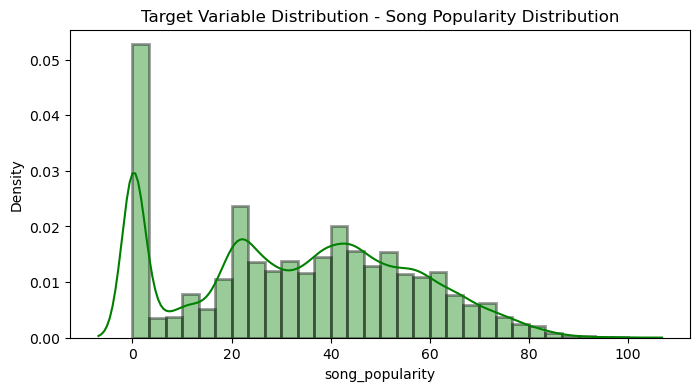

In [318]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Song Popularity Distribution')
plt.show()

## Visualising the 'track_genre' feature

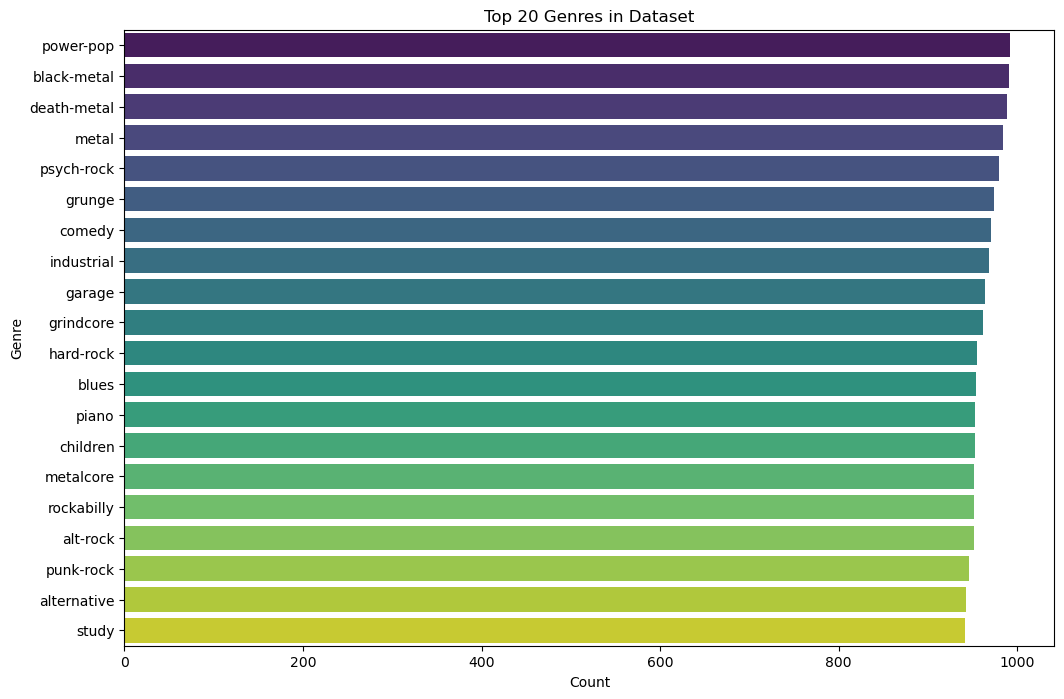

In [249]:
# Define the column name explicitly
genre_column = "track_genre"  # Ensure this is the correct column name

# Select top 20 genres only
top_20_genres = df[genre_column].value_counts().head(20)

# Set figure size
plt.figure(figsize=(12, 8))

# Plot Bar Chart
sns.barplot(y=top_20_genres.index, x=top_20_genres.values, palette="viridis")

plt.xlabel("Count")
plt.ylabel("Genre")
plt.title("Top 20 Genres in Dataset")

plt.show()

## Visualising the numerical features

                                 Numeric Features Distribution                                  


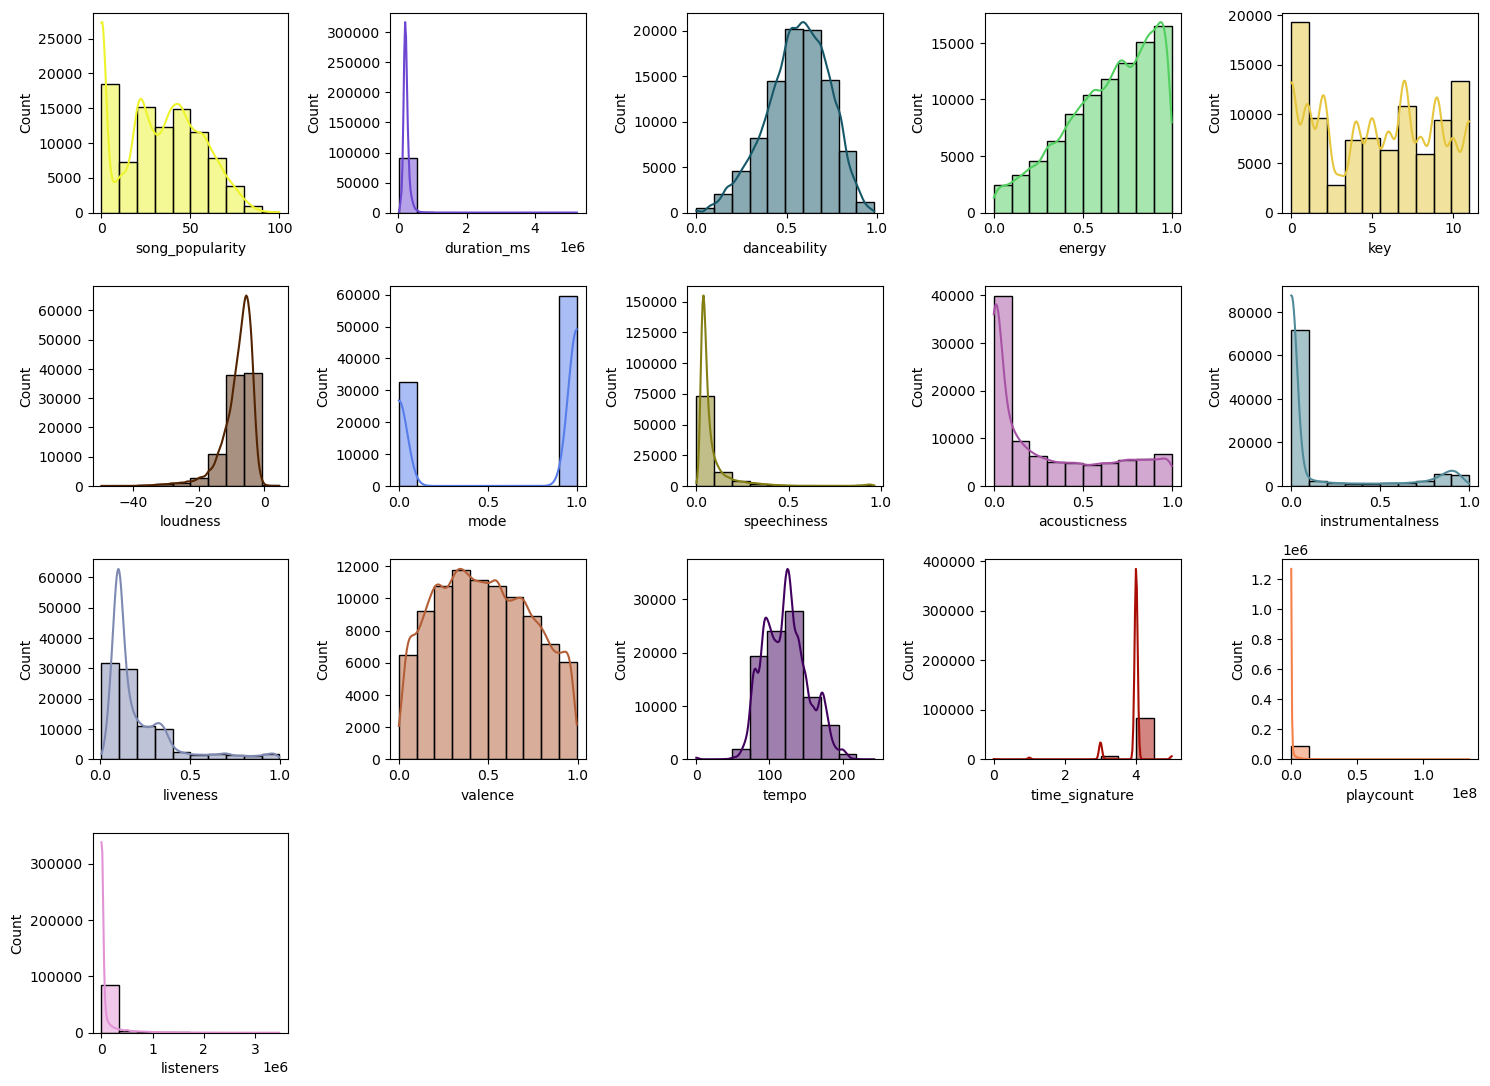

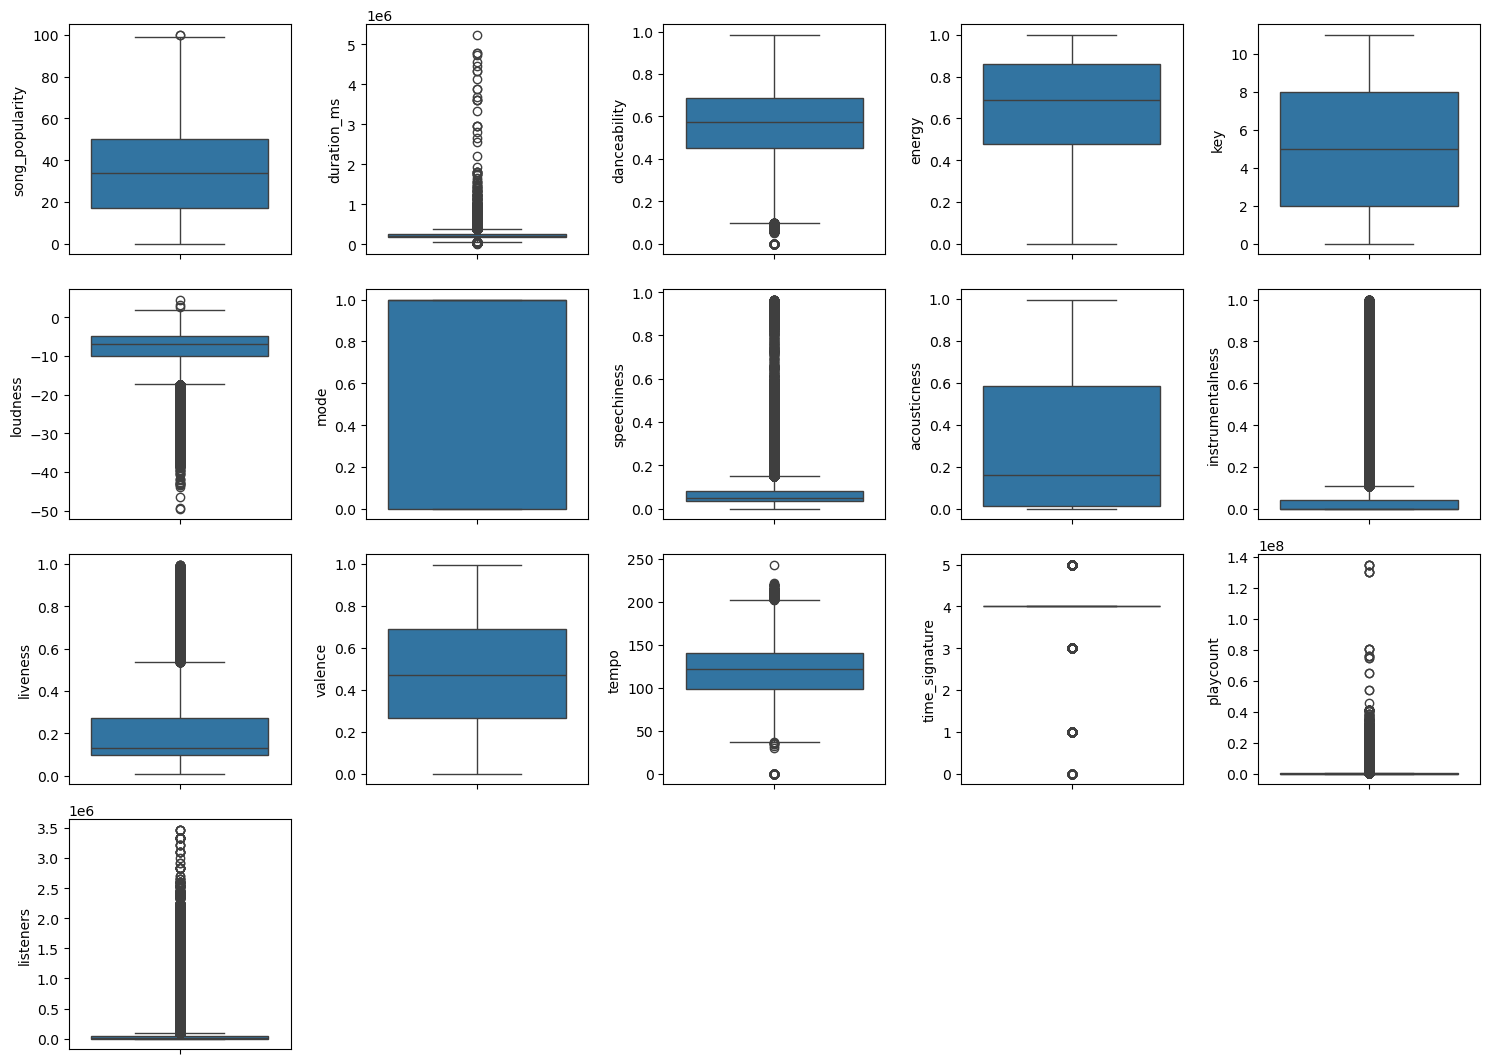

In [112]:
# Ensure nf contains only numeric columns (int64, float64)
nf = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Visualizing numeric features
print('\033[1mNumeric Features Distribution'.center(100))

n = 5

plt.figure(figsize=[15, 4 * math.ceil(len(nf) / n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf) / 3), n, i + 1)
    sns.histplot(df[nf[i]], bins=10, kde=True, color=np.random.rand(3,))
plt.tight_layout()
plt.show()

# Boxplot for numeric features
plt.figure(figsize=[15, 4 * math.ceil(len(nf) / n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf) / 3), n, i + 1)
    sns.boxplot(y=df[nf[i]])
plt.tight_layout()
plt.show()

### Correlation Heatmap

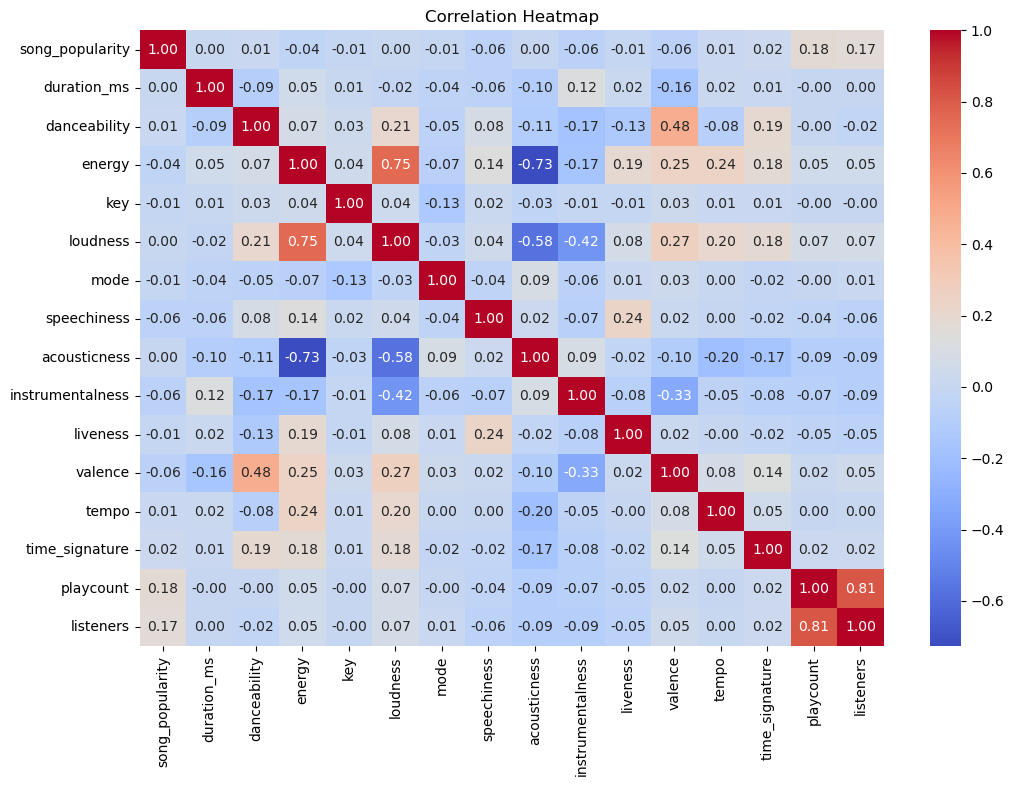

In [251]:
# Select only numeric columns for correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Pairplot of Sampled Features

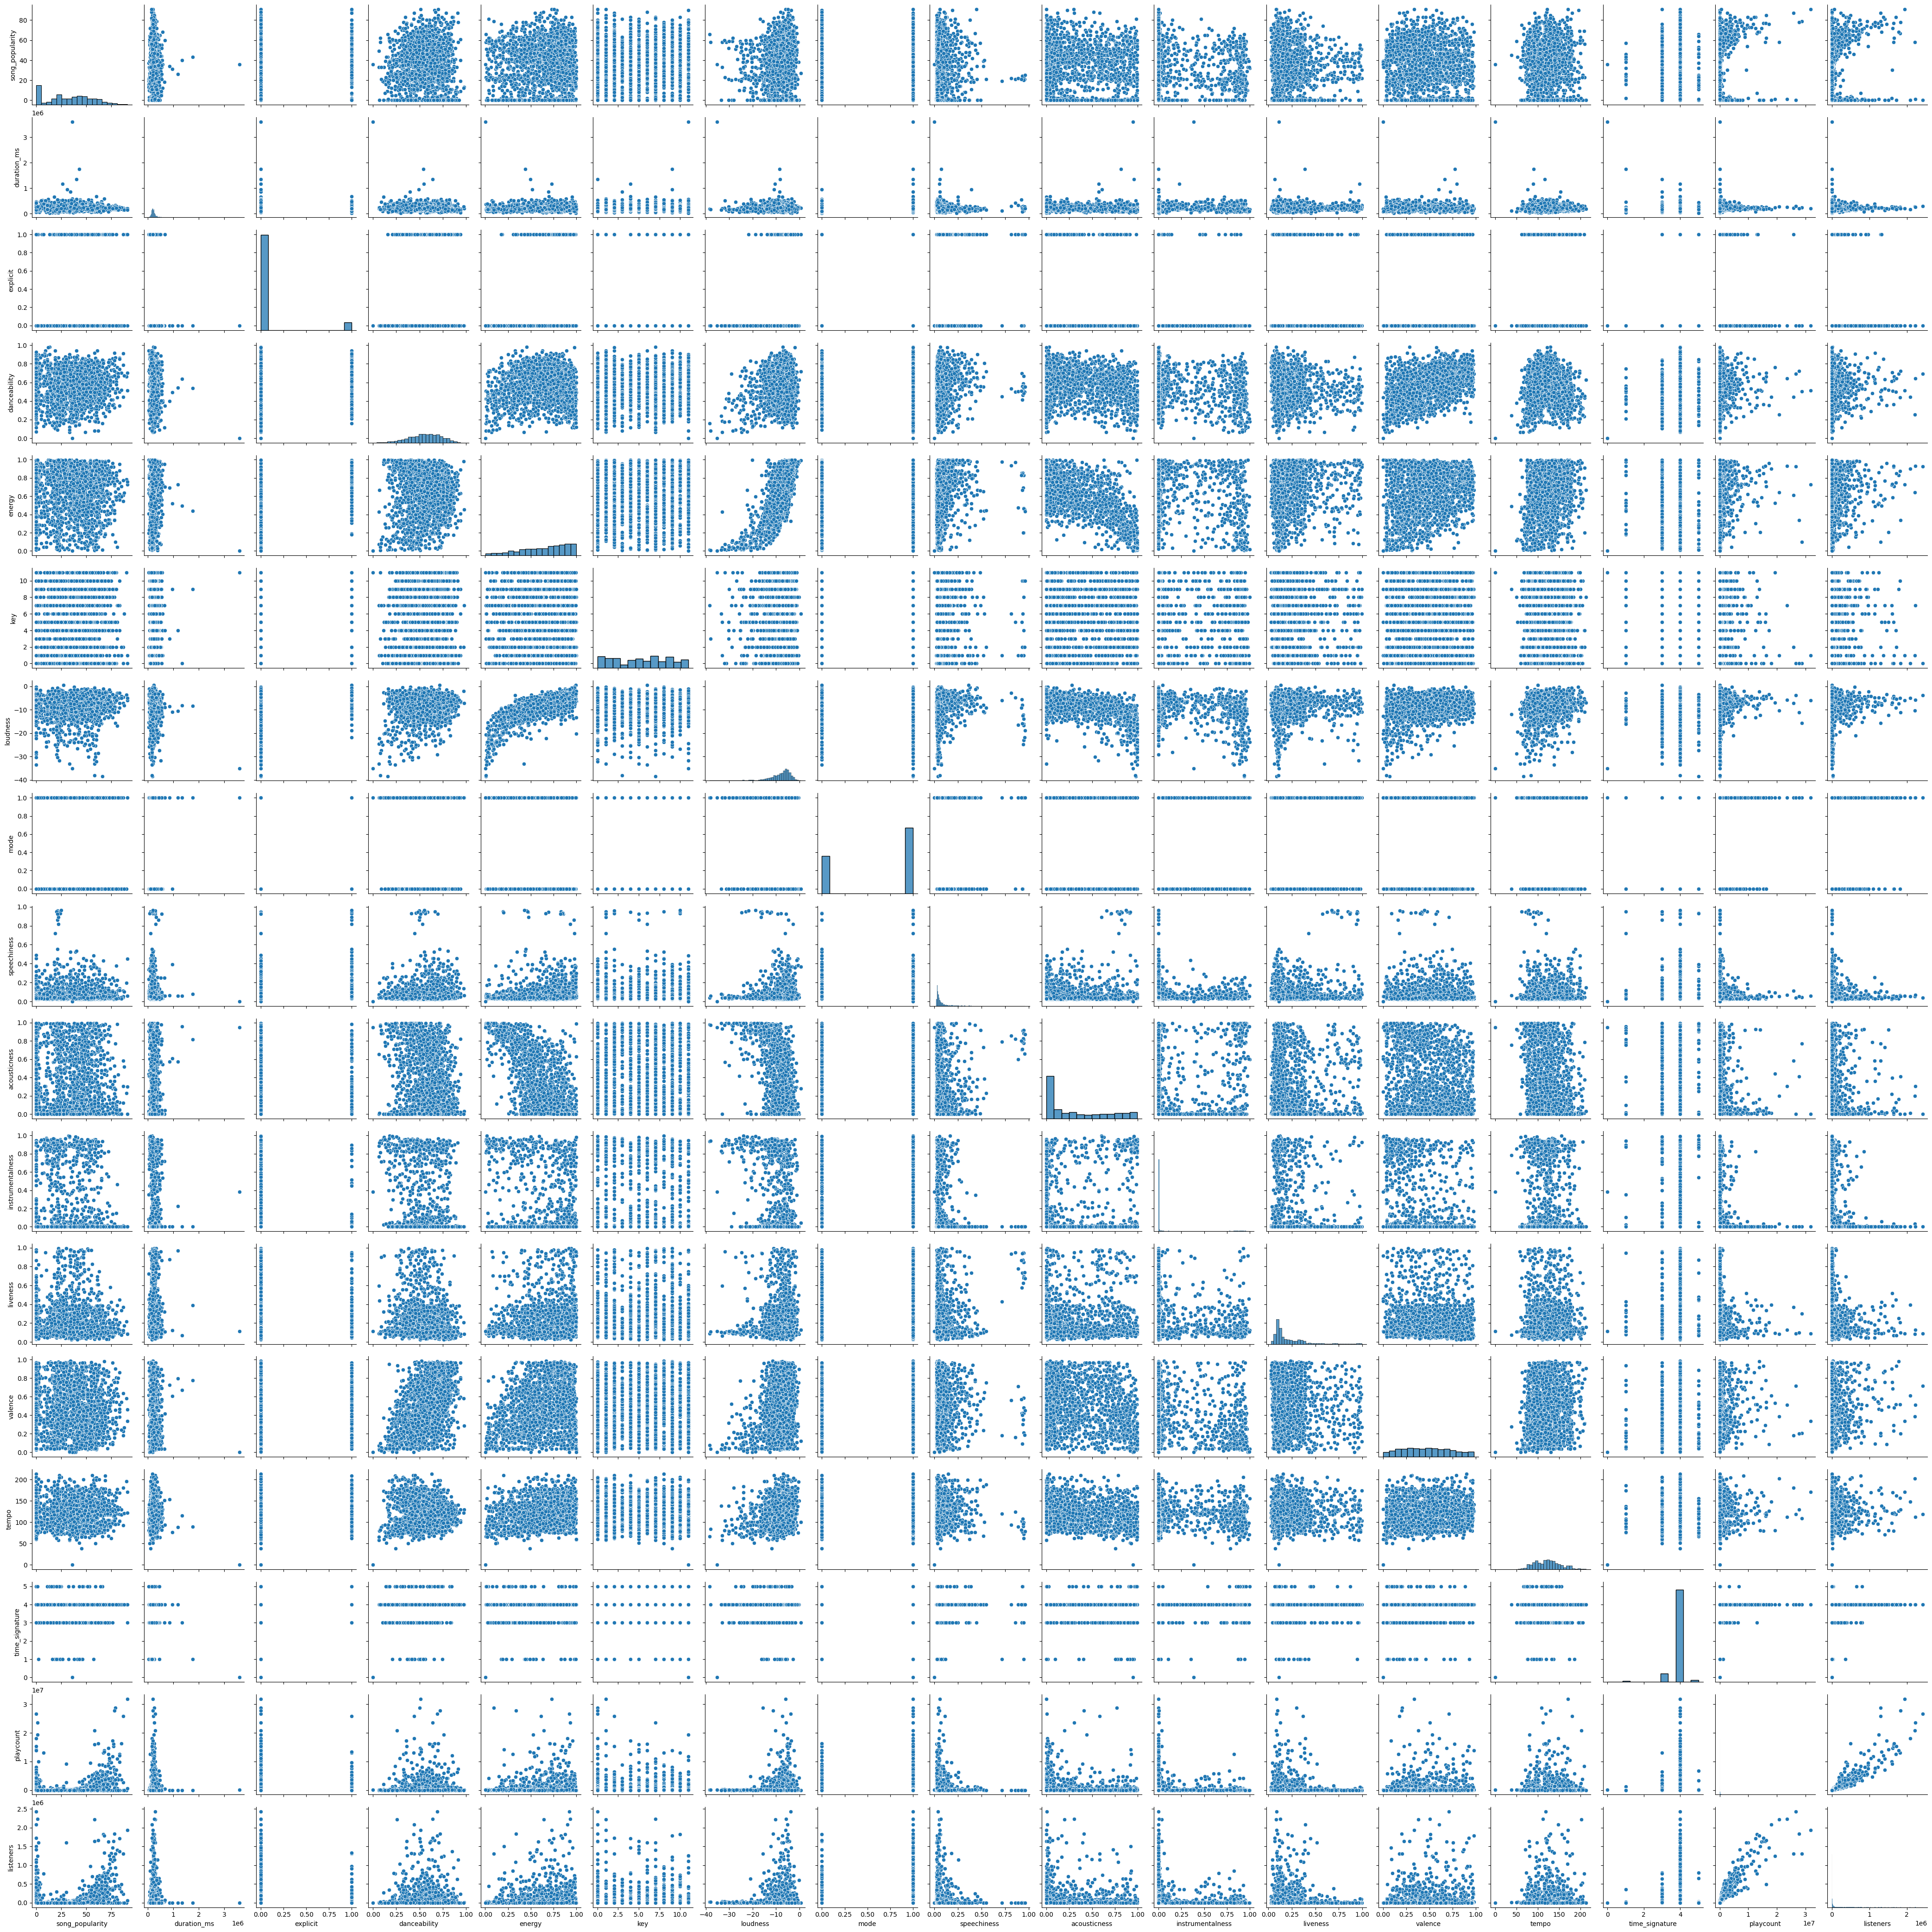

In [117]:
df_sample = df.sample(2000, random_state=42)
sns.pairplot(df_sample)
plt.show()

#### <font color="green">Interpretation</font>

The pairplot provides a visual representation of relationships between numerical features in the dataset. It helps identify correlations, trends, and potential outliers. The scatter plots reveal that play count and listeners are strongly correlated with song popularity, while audio features exhibit weaker relationships. This suggests that streaming metadata plays a more significant role in determining a song's success.

---

# 6. Data Manipulation

## Convert categorical features to numerical using One-Hot Encoding

In [320]:
# Detect categorical columns (non-numeric columns)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Apply One-Hot Encoding to categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first=True to avoid multicollinearity

# Display the new dataframe with encoded columns
print(f"Categorical columns converted to numeric: {categorical_cols}")
print(df_encoded.head())

Categorical columns converted to numeric: ['track_genre']
   song_popularity  duration_ms  explicit  danceability  energy  key  \
0               73       230666     False         0.676   0.461    1   
1               74       244800     False         0.627   0.363    8   
2               75       242946     False         0.703   0.444   11   
3                0       131760     False         0.620   0.309    5   
4                0       306794     False         0.474   0.519    7   

   loudness  mode  speechiness  acousticness  ...  track_genre_spanish  \
0    -6.746     0       0.1430        0.0322  ...                False   
1    -8.127     1       0.0291        0.2790  ...                False   
2    -9.331     1       0.0417        0.5590  ...                False   
3    -9.209     1       0.0495        0.7880  ...                False   
4    -5.291     1       0.0253        0.2810  ...                False   

   track_genre_study  track_genre_swedish  track_genre_synth-pop

In [322]:
print("Categorical columns converted to numeric:", [col for col in df_encoded.columns if col not in df.columns])

Categorical columns converted to numeric: ['track_genre_afrobeat', 'track_genre_alt-rock', 'track_genre_alternative', 'track_genre_ambient', 'track_genre_anime', 'track_genre_black-metal', 'track_genre_bluegrass', 'track_genre_blues', 'track_genre_brazil', 'track_genre_breakbeat', 'track_genre_british', 'track_genre_cantopop', 'track_genre_chicago-house', 'track_genre_children', 'track_genre_chill', 'track_genre_classical', 'track_genre_club', 'track_genre_comedy', 'track_genre_country', 'track_genre_dance', 'track_genre_dancehall', 'track_genre_death-metal', 'track_genre_deep-house', 'track_genre_detroit-techno', 'track_genre_disco', 'track_genre_disney', 'track_genre_drum-and-bass', 'track_genre_dub', 'track_genre_dubstep', 'track_genre_edm', 'track_genre_electro', 'track_genre_electronic', 'track_genre_emo', 'track_genre_folk', 'track_genre_forro', 'track_genre_french', 'track_genre_funk', 'track_genre_garage', 'track_genre_german', 'track_genre_gospel', 'track_genre_goth', 'track_g

---

# 7. Dataset Splitting 

In [324]:
# Define features (X) and target (y)
X = df_encoded.drop(columns=['song_popularity'], errors='ignore')  # Drop target column
y = df_encoded['song_popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Testing Set Size: {X_test.shape[0]} samples")

Training Set Size: 73895 samples
Testing Set Size: 18474 samples


# 8. Feature Selection

## Random Forest Feature Importance (RF Importance) 

In [326]:
def get_rfi(X_train, y_train, top_n=15):
    """
    Trains a Random Forest Classifier and extracts the top N most important features.
    
    Parameters:
        X_train (DataFrame): Training feature set.
        y_train (Series): Target variable.
        top_n (int): Number of top features to select (default is 15).

    Returns:
        list: Top N selected features based on importance.
        DataFrame: Full feature importance ranking.
    """
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Compute feature importance
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": rf_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    # Select top N features
    selected_features = feature_importance.head(top_n)["Feature"].tolist()

    print(f"Top {top_n} Features using Random Forest Importance:", selected_features)
    
    return selected_features, feature_importance

# Apply RFI Feature Selection
selected_features_rf, feature_importance_df = get_rfi(X_train, y_train)

Top 15 Features using Random Forest Importance: ['playcount', 'listeners', 'duration_ms', 'acousticness', 'loudness', 'danceability', 'valence', 'tempo', 'speechiness', 'energy', 'liveness', 'instrumentalness', 'key', 'mode', 'time_signature']


## Variance Inflation Factor (VIF)

In [329]:
def calculate_vif(df, threshold=10):
    """
    Removes features with high multicollinearity using Variance Inflation Factor (VIF).
    
    Parameters:
    - df: DataFrame containing only numerical features.
    - threshold: VIF threshold (default = 10). Features with VIF > threshold are removed.

    Returns:
    - selected_features_vif: List of selected features after removing high VIF ones.
    """
    X = df.copy()  # Copy dataset to avoid modifying original
    dropped = True  # Flag to track feature removal
    
    while dropped:
        dropped = False
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        max_vif = vif_data["VIF"].max()
        if max_vif > threshold:
            drop_feature = vif_data.sort_values(by="VIF", ascending=False).iloc[0]["Feature"]
            X.drop(columns=[drop_feature], inplace=True)
            dropped = True  # Set flag to True to continue iteration

    selected_features_vif = X.columns.tolist()
    return selected_features_vif

# Ensure dataset only contains numerical features
numerical_features = df_encoded.select_dtypes(include=[np.number]).drop(columns=['song_popularity'], errors='ignore')

# Apply VFI Feature Selection
selected_features_vif = calculate_vif(numerical_features, threshold=10)
print("Selected Features using Variance Inflation Factor (VFI):", selected_features_vif)

Selected Features using Variance Inflation Factor (VFI): ['duration_ms', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'playcount', 'listeners']


## LASSO (Least Absolute Shrinkage and Selection Operator)

In [332]:
def select_features_lasso(X, y, alpha=0.01):
    """
    Performs feature selection using LASSO (L1 Regularization).
    
    Parameters:
    - X: Feature matrix (only numerical values).
    - y: Target variable.
    - alpha: Regularization strength (default = 0.01).
    
    Returns:
    - selected_features_lasso: List of selected features.
    """
    # Standardize the data (LASSO is sensitive to scale)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LASSO model
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)
    
    # Select features with non-zero coefficients
    selected_features_lasso = X.columns[lasso.coef_ != 0].tolist()
    return selected_features_lasso

# Ensure dataset only contains numerical features
numerical_features = df_encoded.select_dtypes(include=['number']).drop(columns=['song_popularity'], errors='ignore')

# Apply LASSO Feature Selection
selected_features_lasso = select_features_lasso(numerical_features, df_encoded['song_popularity'], alpha=0.01)
print("Selected Features using LASSO (L1 Regularization):", selected_features_lasso)

Selected Features using LASSO (L1 Regularization): ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'playcount', 'listeners']


---

# 9. Data Normalisation

In [336]:
def standardize_data(X_train, X_test):
    """
    Standardizes the numerical features of the dataset.
    - Fits StandardScaler on training data.
    - Transforms both training and testing data.
    - Prints summary statistics before and after standardization.
    - Returns DataFrames with standardized values.
    """
    # Initialize StandardScaler
    scaler = StandardScaler()
    
    # Apply Standardization
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    # Convert back to DataFrame
    X_train_std_df = pd.DataFrame(X_train_std, columns=X_train.columns)
    X_test_std_df = pd.DataFrame(X_test_std, columns=X_test.columns)

    # Print transformed data statistics after standardization
    print("\nAfter Standardization:".center(120))
    print("Training Set (Standardized):")
    display(X_train_std_df.describe())
    print("\nTesting Set (Standardized):")
    display(X_test_std_df.describe())

    return X_train_std_df, X_test_std_df

In [338]:
X_train_std, X_test_std = standardize_data(X_train, X_test)

                                                
After Standardization:                                                 
Training Set (Standardized):


duration_ms      explicit  danceability        energy           key  \
count  7.389500e+04  7.389500e+04  7.389500e+04  7.389500e+04  7.389500e+04   
mean  -1.159999e-16 -3.813176e-17 -2.312545e-17  3.942385e-18 -8.735748e-17   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -2.048806e+00 -3.027937e-01 -3.282853e+00 -2.601604e+00 -1.488577e+00   
25%   -5.002000e-01 -3.027937e-01 -6.389100e-01 -6.854820e-01 -9.262948e-01   
50%   -1.309664e-01 -3.027937e-01  6.887133e-02  1.661635e-01 -8.287182e-02   
75%    3.141024e-01 -3.027937e-01  7.357066e-01  8.490867e-01  7.605512e-01   
max    4.386997e+01  3.302579e+00  2.478838e+00  1.415511e+00  1.603974e+00   

           loudness          mode   speechiness  acousticness  \
count  7.389500e+04  7.389500e+04  7.389500e+04  7.389500e+04   
mean   1.989943e-16  1.096175e-17  7.889577e-17 -1.078386e-16   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -8.575363e+00 -1.351786e+00 -7.685284e-01 -9.358708e-01   
25%   -3.748189e-01 -1.351786e+00 -4.429975e-01 -8.930140e-01   
50%    2.455697e-01  7.397619e-01 -3.249580e-01 -4.495531e-01   
75%    6.522562e-01  7.397619e-01 -1.325983e-02  8.452678e-01   
max    2.625193e+00  7.397619e-01  8.130545e+00  2.091457e+00   

       instrumentalness  ...  track_genre_spanish  track_genre_study  \
count      7.389500e+04  ...         7.389500e+04       7.389500e+04   
mean      -2.620244e-17  ...        -2.418317e-17       7.247738e-17   
std        1.000007e+00  ...         1.000007e+00       1.000007e+00   
min       -4.990712e-01  ...        -9.507702e-02      -1.020076e-01   
25%       -4.990712e-01  ...        -9.507702e-02      -1.020076e-01   
50%       -4.989382e-01  ...        -9.507702e-02      -1.020076e-01   
75%       -3.560513e-01  ...        -9.507702e-02      -1.020076e-01   
max        2.751380e+00  ...         1.051779e+01       9.803188e+00   

       track_genre_swedish  track_genre_synth-pop  track_genre_tango  \
count         7.389500e+04           7.389500e+04       7.389500e+04   
mean         -3.569781e-17          -6.109494e-17       5.043368e-17   
std           1.000007e+00           1.000007e+00       1.000007e+00   
min          -9.701442e-02          -9.912430e-02      -8.393872e-02   
25%          -9.701442e-02          -9.912430e-02      -8.393872e-02   
50%          -9.701442e-02          -9.912430e-02      -8.393872e-02   
75%          -9.701442e-02          -9.912430e-02      -8.393872e-02   
max           1.030775e+01           1.008834e+01       1.191345e+01   

       track_genre_techno  track_genre_trance  track_genre_trip-hop  \
count        7.389500e+04        7.389500e+04          7.389500e+04   
mean        -4.522925e-17       -1.935134e-17         -2.312545e-17   
std          1.000007e+00        1.000007e+00          1.000007e+00   
min         -9.009620e-02       -8.077415e-02         -9.637279e-02   
25%         -9.009620e-02       -8.077415e-02         -9.637279e-02   
50%         -9.009620e-02       -8.077415e-02         -9.637279e-02   
75%         -9.009620e-02       -8.077415e-02         -9.637279e-02   
max          1.109925e+01        1.238020e+01          1.037637e+01   

       track_genre_turkish  track_genre_world-music  
count         7.389500e+04             7.389500e+04  
mean          4.257295e-17             2.586589e-17  
std           1.000007e+00             1.000007e+00  
min          -9.665846e-02            -8.754240e-02  
25%          -9.665846e-02            -8.754240e-02  
50%          -9.665846e-02            -8.754240e-02  
75%          -9.665846e-02            -8.754240e-02  
max           1.034571e+01             1.142304e+01  

[8 rows x 129 columns]


Testing Set (Standardized):


duration_ms      explicit  danceability        energy           key  \
count  18474.000000  18474.000000  18474.000000  18474.000000  18474.000000   
mean       0.003571     -0.011811      0.018454      0.001167      0.008635   
std        1.067948      0.982080      0.992799      1.001589      1.002187   
min       -1.973289     -0.302794     -3.282853     -2.601604     -1.488577   
25%       -0.502900     -0.302794     -0.621362     -0.685482     -0.926295   
50%       -0.132365     -0.302794      0.080570      0.182232     -0.082872   
75%        0.312290     -0.302794      0.741556      0.849087      0.760551   
max       48.180170      3.302579      2.455440      1.415511      1.603974   

           loudness          mode   speechiness  acousticness  \
count  18474.000000  18474.000000  18474.000000  18474.000000   
mean      -0.002388      0.007935     -0.001690     -0.003535   
std        0.999194      0.997564      0.986842      0.996944   
min       -7.231827     -1.351786     -0.768528     -0.935871   
25%       -0.378807     -1.351786     -0.441153     -0.890810   
50%        0.240183      0.739762     -0.323114     -0.443474   
75%        0.656969      0.739762     -0.013490      0.827031   
max        2.219543      0.739762      8.112102      2.091457   

       instrumentalness  ...  track_genre_spanish  track_genre_study  \
count      18474.000000  ...         18474.000000       18474.000000   
mean          -0.005306  ...             0.010627          -0.005497   
std            0.996246  ...             1.053900           0.972981   
min           -0.499071  ...            -0.095077          -0.102008   
25%           -0.499071  ...            -0.095077          -0.102008   
50%           -0.498954  ...            -0.095077          -0.102008   
75%           -0.371410  ...            -0.095077          -0.102008   
max            2.751380  ...            10.517788           9.803188   

       track_genre_swedish  track_genre_synth-pop  track_genre_tango  \
count         18474.000000           18474.000000       18474.000000   
mean             -0.012533              -0.004275           0.003084   
std               0.933767               0.978432           1.018098   
min              -0.097014              -0.099124          -0.083939   
25%              -0.097014              -0.099124          -0.083939   
50%              -0.097014              -0.099124          -0.083939   
75%              -0.097014              -0.099124          -0.083939   
max              10.307746              10.088344          11.913453   

       track_genre_techno  track_genre_trance  track_genre_trip-hop  \
count        18474.000000        18474.000000          18474.000000   
mean            -0.010752           -0.009950              0.009636   
std              0.938915            0.936785              1.048343   
min             -0.090096           -0.080774             -0.096373   
25%             -0.090096           -0.080774             -0.096373   
50%             -0.090096           -0.080774             -0.096373   
75%             -0.090096           -0.080774             -0.096373   
max             11.099247           12.380198             10.376373   

       track_genre_turkish  track_genre_world-music  
count         18474.000000             18474.000000  
mean             -0.002828                -0.010282  
std               0.985426                 0.939890  
min              -0.096658                -0.087542  
25%              -0.096658                -0.087542  
50%              -0.096658                -0.087542  
75%              -0.096658                -0.087542  
max              10.345706                11.423037  

[8 rows x 129 columns]

# 10. Model Training - Evaluation

## Random Forest Classifier

In [356]:
# Set this flag to True to use standardized data, or False to use original data
use_standardized = False  # Change this as needed

# Select feature selection method: "rfi", "vif", "lasso", or "combined"
feature_selection_method = "combined"

# Ensure categorical features are identified
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns = df_encoded.columns[df_encoded.columns.str.startswith(tuple(categorical_features))].tolist()

# Choose selected features based on feature selection method
feature_selection_dict = {
    "rfi": selected_features_rf,
    "vif": selected_features_vif,
    "lasso": selected_features_lasso,
    "combined": list(set(selected_features_rf + selected_features_vif + selected_features_lasso))
}

if feature_selection_method not in feature_selection_dict:
    raise ValueError("Invalid feature selection method. Choose from 'rfi', 'vif', 'lasso', or 'combined'.")

selected_features = feature_selection_dict[feature_selection_method]

# Choose between Standardized or Original Numerical Data
if use_standardized:
    Train_X_num_df = X_train_std[selected_features].reset_index(drop=True)
    Test_X_num_df = X_test_std[selected_features].reset_index(drop=True)
    print("\nUsing Standardized Numerical Features")
else:
    Train_X_num_df = X_train[selected_features].reset_index(drop=True)
    Test_X_num_df = X_test[selected_features].reset_index(drop=True)
    print("\nUsing Original (Non-Standardized) Numerical Features")

# Extract categorical features for training and testing sets
X_train_categorical = X_train[categorical_columns].reset_index(drop=True)
X_test_categorical = X_test[categorical_columns].reset_index(drop=True)

# Combine numerical and categorical features
X_train_final = pd.concat([Train_X_num_df, X_train_categorical], axis=1)
X_test_final = pd.concat([Test_X_num_df, X_test_categorical], axis=1)

# Initialize and train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_final, y_train)

# Make predictions
y_pred = clf.predict(X_test_final)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy and final features used
print(f"Model Accuracy: {accuracy:.4f}")


Using Original (Non-Standardized) Numerical Features
Model Accuracy: 0.8971


### Generate the confusion matrix

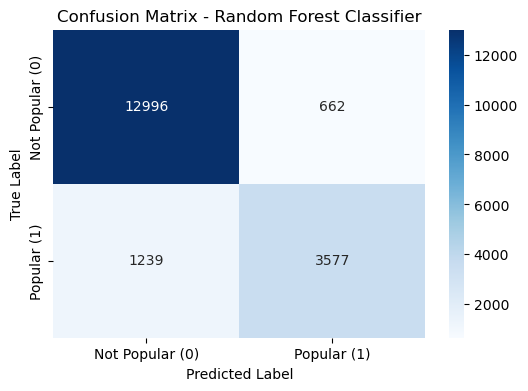

Classification Report:
              precision    recall  f1-score   support

           0     0.9130    0.9515    0.9318     13658
           1     0.8438    0.7427    0.7901      4816

    accuracy                         0.8971     18474
   macro avg     0.8784    0.8471    0.8610     18474
weighted avg     0.8949    0.8971    0.8949     18474



In [359]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Popular (0)', 'Popular (1)'], yticklabels=['Not Popular (0)', 'Popular (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

# Print classification report with 4 decimal places
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


### ROC Curve

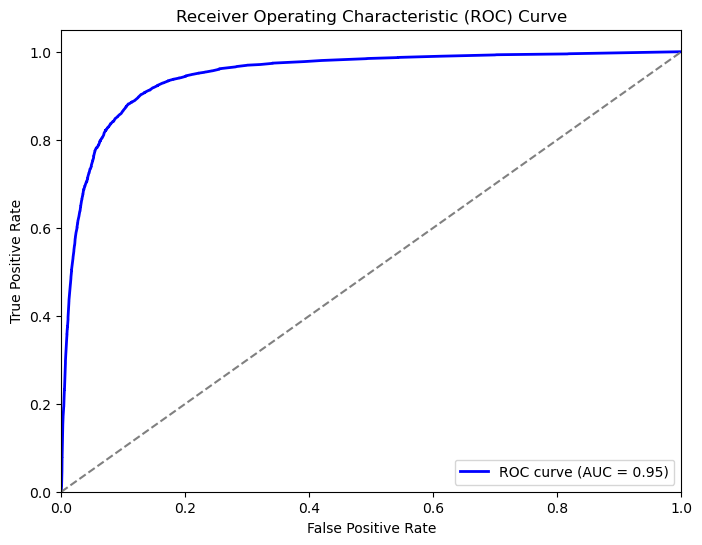

AUC Score: 0.9477


In [350]:
# Get prediction probabilities for the positive class (1)
y_probs = clf.predict_proba(X_test_final)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.4f}")

## Random Forest Regressor


Using Original (Non-Standardized) Numerical Features
Mean Squared Error (MSE): 178.45
Mean Absolute Error (MAE): 8.70
R² Score: 0.6523


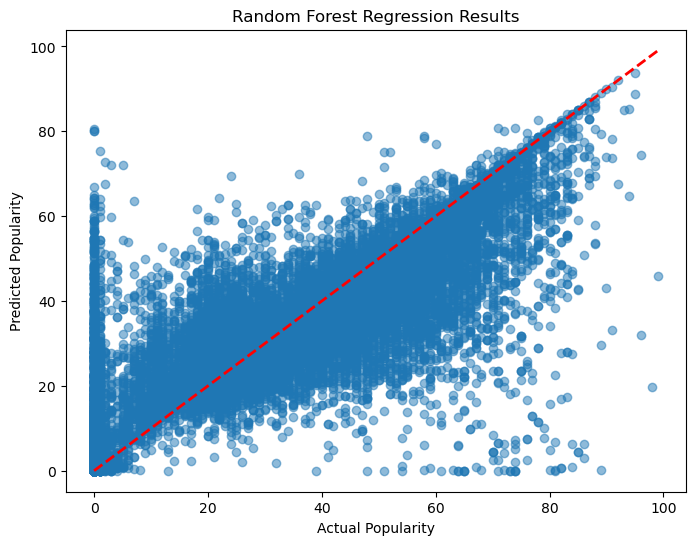

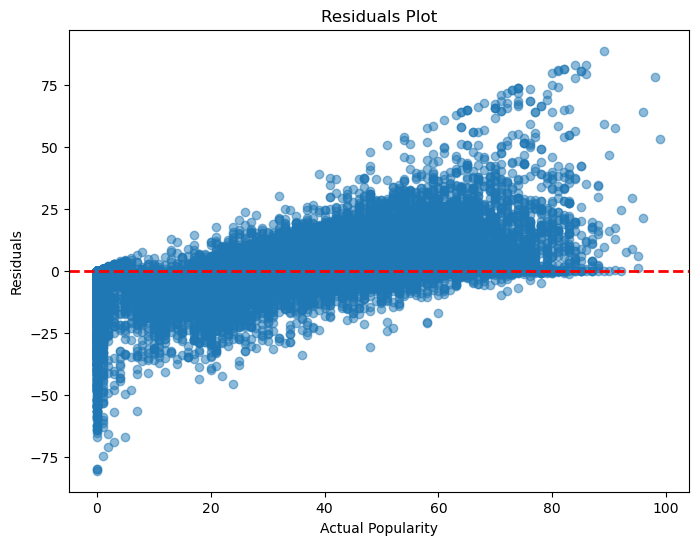

In [272]:
# Set this flag to True to use standardized data, or False to use original data
use_standardized = False  # Change this to True or False as needed

# Choose feature selection method: "rfi", "vif", "lasso", or "combined"
feature_selection_method = "rfi"  # Change as needed

# Define target variable
y = df_encoded['song_popularity']

# Select features based on feature selection method
if feature_selection_method == "rfi":
    selected_features = selected_features_rf
elif feature_selection_method == "vif":
    selected_features = selected_features_vif
elif feature_selection_method == "lasso":
    selected_features = selected_features_lasso
elif feature_selection_method == "combined":
    selected_features = list(set(selected_features_rf + selected_features_vif + selected_features_lasso))  # Merge all
else:
    raise ValueError("Invalid feature selection method. Choose from 'rfi', 'vif', 'lasso', or 'combined'.")

# Choose between Standardized or Original Numerical Data
if use_standardized:
    # Use Standardized Data
    Train_X_num_df = X_train_std[selected_features].copy()
    Test_X_num_df = X_test_std[selected_features].copy()
    print("\nUsing Standardized Numerical Features")
else:
    # Use Original Data (No Standardization)
    Train_X_num_df = X_train[selected_features].reset_index(drop=True)
    Test_X_num_df = X_test[selected_features].reset_index(drop=True)
    print("\nUsing Original (Non-Standardized) Numerical Features")

# Train Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=10, random_state=42)
regressor.fit(Train_X_num_df, y_train)

# Make predictions
y_pred = regressor.predict(Test_X_num_df)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualization (Scatter & Residual Plots)
def plot_results(y_test, y_pred, title="Model Performance"):
    """
    Creates scatter and residual plots for regression results.
    """
    # Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Actual Popularity")
    plt.ylabel("Predicted Popularity")
    plt.title(title)
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel("Actual Popularity")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.show()

plot_results(y_test, y_pred, title="Random Forest Regression Results")

### Additional Comment for Both Models

Standardization was tested but did not improve model performance, so the final models were trained using the original numerical features.